# Padding and Stride

In the example in the previous section,we used an input with a height and width of 3 and a convolution kernel with a height and width of 2 to get an output with a height and a width of 2. In general, assuming the input shape is n<sub>h</sub> × n<sub>w</sub> and the convolution kernel window shape is k<sub>h</sub> × k<sub>w</sub> , then the output shape will be (n<sub>h</sub> − k<sub>h</sub> + 1) × (n<sub>w</sub> − k<sub>w</sub> + 1).
Therefore, the output shape of the convolutional layer is determined by the shape of the input and the shape of the convolution kernel window. In several cases we might want to change the dimensionality of
the output:

• Multiple layers of convolutions reduce the information available at the boundary, often by much
more than what we would want. If we start with a 240x240 pixel image, 10 layers of 5x5 convo-
lutions reduce the image to 200x200 pixels, effectively slicing off 30% of the image and with it
obliterating anything interesting on the boundaries. Padding mitigates this problem.
• In some cases we want to reduce the resolution drastically, e.g. halving it if we think that such
a high input dimensionality is not required. In this case we might want to subsample the output.
Strides address this.

• In some cases we want to increase the resolution, e.g. for image superresolution or for audio
generation. Again, strides come to our rescue.

• In some cases we want to increase the length gently to a given size (mostly for sentences of variable
length or for filling in patches). Padding addresses this.

## Padding

As we saw so far, convolutions are quite useful. Alas, on the boundaries we encounter the problem
that we keep on losing pixels. For any given convolution it’s only a few pixels but this adds up as we
discussed above. If the image was larger things would be easier - we could simply record one that’s
larger. Unfortunately, that’s not what we get in reality. One solution to this problem is to add extra
pixels around the boundary of the image, thus increasing the effective size of the image (the extra pixels
typically assume the value 0). In the figure below we pad the 3×5 to increase to 5×7. The corresponding
output then increases to a 4×6 matrix.

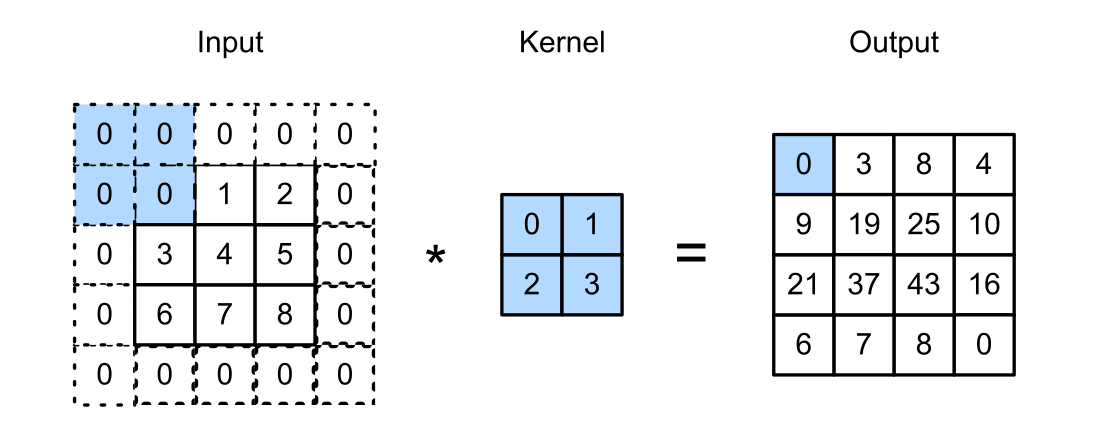

In [1]:
from IPython.display import Image
Image(filename="img/padding.png")

Fig. 6.2: Two-dimensional cross-correlation with padding. The shaded portions are the input and kernel
array elements used by the first output element: 0×0 + 0×1 + 0×2 + 0×3 = 0.

In general, if a total of p<sub>h</sub> rows are padded on both sides of the height and a total of p<sub>w</sub> columns are
padded on both sides of width, the output shape will be (n<sub>h</sub> − k<sub>h</sub> + p<sub>h</sub> + 1) × (n<sub>w</sub> − k<sub>w</sub> + p<sub>w</sub> + 1),
This means that the height and width of the output will increase by p<sub>h</sub> and p<sub>w</sub> respectively.

In many cases, we will want to set p<sub>h</sub> = k<sub>h</sub> − 1 and p<sub>w</sub> = k<sub>w</sub> − 1 to give the input and output the same
height and width. This will make it easier to predict the output shape of each layer when constructing the
network. Assuming that k<sub>h</sub> is odd here, we will pad p<sub>h</sub> /2 rows on both sides of the height. If k<sub>h</sub> is even,
one possibility is to pad ⌈p<sub>h</sub> /2⌉ rows on the top of the input and ⌊p<sub>h</sub> /2⌋ rows on the bottom. We will pad
both sides of the width in the same way.

Convolutional neural networks often use convolution kernels with odd height and width values, such as
1, 3, 5, and 7, so the number of padding rows or columns on both sides are the same. For any two-
dimensional array X, assume that the element in its ith row and jth column is X[i,j]. When the
number of padding rows or columns on both sides are the same so that the input and output have the same
height and width, we know that the output Y[i,j] is calculated by cross-correlation of the input and
convolution kernel with the window centered on X[i,j].

In the following example we create a two-dimensional convolutional layer with a height and width of 3,
and then assume that the padding number on both sides of the input height and width is 1. Given an input
with a height and width of 8, we find that the height and width of the output is also 8.

In [2]:
import torch
import torch.nn as nn
# We define a convenience function to calculate the convolutional layer. This 
# function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    # (1,1) indicates that the batch size and the number of channels
    # (described in later chapters) are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: batch and
    # channel
    return Y.reshape(Y.shape[2:])
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have
the same height and width by setting different padding numbers for height and width.

In [3]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on both sides of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## Stride
When computing the cross-correlation the convolution window starts from the top-left of the input array,
and slides in the input array from left to right and top to bottom. We refer to the number of rows and
columns per slide as the stride.

In the current example, the stride is 1, both in terms of height and width. We can also use a larger stride.
The figure below shows a two-dimensional cross-correlation operation with a stride of 3 vertically and
2 horizontally. We can see that when the second element of the first column is output, the convolution
window slides down three rows. The convolution window slides two columns to the right when the second
element of the first row is output. When the convolution window slides two columns to the right on the
input, there is no output because the input element cannot fill the window (unless we add padding).

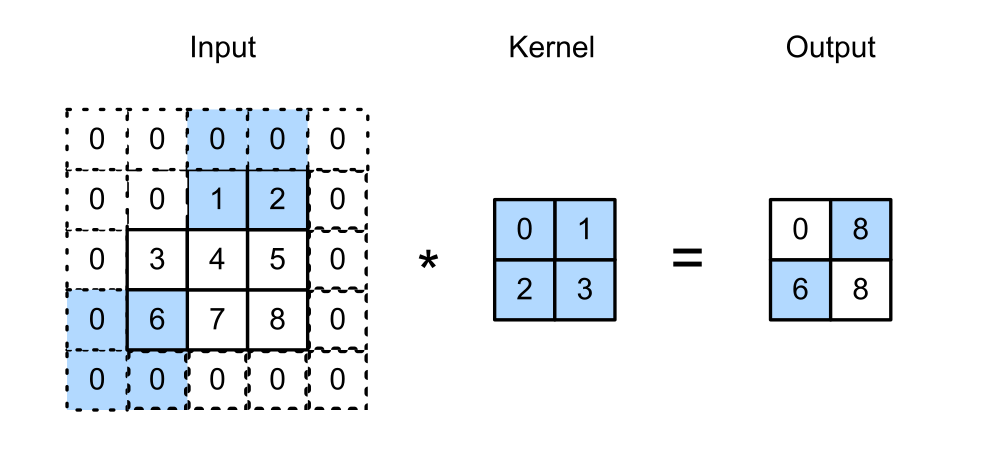

In [4]:
Image(filename="img/stride.png")

Fig.6.3: Cross-correlation with strides of 3 and 2 for height and width respectively. The shaded portions
are the output element and the input and core array elements used in its computation: 0×0 + 0×1 + 1×2 + 2×3 = 8, 0×0 + 6×1 + 0×2 + 0×3 = 6.

In general, when the stride for the height is s<sub>h</sub> and the stride for the width is s<sub>w</sub>,the output shape is ⌊(n<sub>h</sub> − k<sub>h</sub> + p<sub>h</sub> + s<sub>h</sub> ) / s<sub>h</sub> ⌋ × ⌊(n<sub>w</sub> − k<sub>w</sub> + p<sub>w</sub> + s<sub>w</sub> ) / s<sub>w</sub> ⌋.

If we set p<sub>h</sub> = k<sub>h</sub> − 1 and p<sub>w</sub> = k<sub>w</sub> − 1,
then the output shape will be simplified to <br> ⌊(n<sub>h</sub> + s<sub>h</sub> − 1) / s<sub>h</sub> ⌋ × ⌊(n<sub>w</sub> + s<sub>w</sub> − 1) / s<sub>w</sub> ⌋. 

Going a step further, if the input height and width are divisible by the strides on
the height and width, then the output shape will be (n<sub>h</sub> / s<sub>h</sub> ) × (n<sub>w</sub> / s<sub>w</sub> ).

Below, we set the strides on both the height and width to 2, thus halving the input height and width.

In [5]:
conv2d = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

Next, we will look at a slightly more complicated example.

In [6]:
conv2d = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

For the sake of brevity, when the padding number on both sides of the input height and width are p<sub>h</sub> and
p<sub>w</sub> respectively, we call the padding (p<sub>h</sub> , p<sub>w</sub> ). Specifically, when p<sub>h</sub> = p<sub>w</sub> = p, the padding is p. When
the strides on the height and width are s<sub>h</sub> and s<sub>w</sub> , respectively, we call the stride (s<sub>h</sub>,s<sub>w</sub>). Specifically,
when s<sub>h</sub> = s<sub>w</sub> = s, the stride is s. By default, the padding is 0 and the stride is 1. In practice we rarely
use inhomogeneous strides or padding, i.e. we usually have p<sub>h</sub> = p<sub>w</sub> and s<sub>h</sub> = s<sub>w</sub> .

## Summary

 • Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.
 
 • The stride can reduce the resolution of the output, for example reducing the height and width of the output to only 1/n of the height and width of the input (n is an integer greater than 1).
 
 • Padding and stride can be used to adjust the dimensionality of the data effectively.

## Exercises
 1. or the last example in this section, use the shape calculation formula to calculate the output shape to see if it is consistent with the experimental results.
 
 
 2. Try other padding and stride combinations on the experiments in this section.
 
 
 3. For audio signals, what does a stride of 2 correspond to?
 
 
 4. What are the computational benefits of a stride larger than 1.